# Imports and setup

In [1]:
# Setup
import sys
from pathlib import Path
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import FocalLoss
import torch.nn as nn
import torch
import tqdm

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.data.datasets import CNNIberFireDataset
from torch.utils.data import DataLoader

ZARR_PATH = project_root / "data" / "silver" / "IberFire.zarr"
NUM_EPOCHS = 5

# Dataset creation, loading

In [9]:
from src.data.datasets import SimpleIberFireSegmentationDataset
from torch.utils.data import DataLoader

feature_vars = [
    "wind_speed_mean",
    "t2m_mean",
    "RH_mean",
    "total_precipitation_mean",
    "is_holiday",
    "surface_pressure_mean",
    "popdens_2020",
    "elevation_mean",
    "elevation_stdev",
    "dist_to_railways_mean",
    "dist_to_roads_mean",
    "dist_to_waterways_mean",
    "roughness_mean",
    "slope_mean",
    "CLC_2018_forest_proportion",
    "CLC_2018_open_space_proportion",
    "CLC_2018_arable_land_proportion",   
]

in_channels = len(feature_vars)
TRAIN_STATS_PATH = project_root / "stats" / "simple_iberfire_stats_train.json"
train_ds = SimpleIberFireSegmentationDataset(
    zarr_path=ZARR_PATH,
    time_start="2017-01-01",
    time_end="2020-12-31",
    feature_vars=feature_vars,
    label_var="is_near_fire",
    spatial_downsample=4,
    lead_time=0,         # predict today
    compute_stats=True,  # or precompute & pass stats
    stats_path = TRAIN_STATS_PATH
)

train_loader = DataLoader(
    train_ds,
    batch_size=6,       
    shuffle=True,
    num_workers=4,
    persistent_workers=True,
    pin_memory=False
)

[SimpleDataset] Opening Zarr dataset: /Users/vladimir/catalonia-wildfire-prediction/data/silver/IberFire.zarr
[SimpleDataset] Filtering time range: 2017-01-01 to 2020-12-31
[SimpleDataset] Total usable time steps: 1461
[SimpleDataset] Dynamic vars (time-dependent): ['wind_speed_mean', 't2m_mean', 'RH_mean', 'total_precipitation_mean', 'is_holiday', 'surface_pressure_mean']
[SimpleDataset] Static vars (no time dimension, broadcast in time): ['popdens_2020', 'elevation_mean', 'elevation_stdev', 'dist_to_railways_mean', 'dist_to_roads_mean', 'dist_to_waterways_mean', 'roughness_mean', 'slope_mean', 'CLC_2018_forest_proportion', 'CLC_2018_open_space_proportion', 'CLC_2018_arable_land_proportion']
[SimpleDataset] Cached static var 'popdens_2020' with shape (230, 297) and dtype float32
[SimpleDataset] Cached static var 'elevation_mean' with shape (230, 297) and dtype float32
[SimpleDataset] Cached static var 'elevation_stdev' with shape (230, 297) and dtype float32
[SimpleDataset] Cached sta

In [10]:
X, y = train_ds[0]
print(f"Feature tensor shape: {X.shape}, Label tensor shape: {y.shape}")
print(train_ds.get_time_value(0))


Feature tensor shape: torch.Size([17, 230, 297]), Label tensor shape: torch.Size([1, 230, 297])
2017-01-01T00:00:00.000000000


In [11]:
# test dataset
test_ds = SimpleIberFireSegmentationDataset(
    zarr_path=ZARR_PATH,
    time_start="2021-01-01",
    time_end="2021-12-31",
    feature_vars=feature_vars,
    label_var="is_near_fire",
    spatial_downsample=4,
    lead_time=0,
    compute_stats=False,
    stats_path=TRAIN_STATS_PATH
)
test_loader = DataLoader(
    test_ds,
    batch_size=6,
    shuffle=False,
    num_workers=4,
    persistent_workers=True,
    pin_memory=False 
)

[SimpleDataset] Opening Zarr dataset: /Users/vladimir/catalonia-wildfire-prediction/data/silver/IberFire.zarr
[SimpleDataset] Filtering time range: 2021-01-01 to 2021-12-31
[SimpleDataset] Total usable time steps: 365
[SimpleDataset] Dynamic vars (time-dependent): ['wind_speed_mean', 't2m_mean', 'RH_mean', 'total_precipitation_mean', 'is_holiday', 'surface_pressure_mean']
[SimpleDataset] Static vars (no time dimension, broadcast in time): ['popdens_2020', 'elevation_mean', 'elevation_stdev', 'dist_to_railways_mean', 'dist_to_roads_mean', 'dist_to_waterways_mean', 'roughness_mean', 'slope_mean', 'CLC_2018_forest_proportion', 'CLC_2018_open_space_proportion', 'CLC_2018_arable_land_proportion']
[SimpleDataset] Cached static var 'popdens_2020' with shape (230, 297) and dtype float32
[SimpleDataset] Cached static var 'elevation_mean' with shape (230, 297) and dtype float32
[SimpleDataset] Cached static var 'elevation_stdev' with shape (230, 297) and dtype float32
[SimpleDataset] Cached stat

# Model - training

In [12]:
model = smp.Unet(
    encoder_name="resnet34",      # or "timm-efficientnet-b0", etc.
    encoder_weights="imagenet",          # or None if you don't want pretrained
    in_channels=in_channels,               # IberFire: number of feature channels per pixel
    classes=1,                    # 1 output channel for fire / no-fire probability
    activation=None               # we'll apply sigmoid later in the loss/metrics
)

In [13]:
# sanity check
X, y = train_ds[0]                      # X: [C, H, W], y: [1, H, W]
X = X.unsqueeze(0)                      # [1, C, H, W]
with torch.no_grad():
    out = model(X)

print("Input :", X.shape)               # [1, 4, H, W]
print("Target:", y.unsqueeze(0).shape)  # [1, 1, H, W]
print("Output:", out.shape)            # should be [1, 1, H, W]

Input : torch.Size([1, 17, 230, 297])
Target: torch.Size([1, 1, 230, 297])
Output: torch.Size([1, 1, 230, 297])


In [14]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
model = model.to(device)
pos_weight = torch.tensor([10.0], device=device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

Using device: mps


In [15]:
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", ncols = 100)
    for X_batch, y_batch in pbar:
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

        pbar.set_postfix({"loss": loss.item()})

    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {train_loss:.4f}")

Epoch 1/5: 100%|██████████████████████████████████████| 244/244 [17:18<00:00,  4.26s/it, loss=0.447]


Epoch 1/5, Training Loss: 0.4193


Epoch 2/5: 100%|██████████████████████████████████████| 244/244 [17:00<00:00,  4.18s/it, loss=0.233]


Epoch 2/5, Training Loss: 0.2976


Epoch 3/5: 100%|██████████████████████████████████████| 244/244 [16:48<00:00,  4.13s/it, loss=0.341]


Epoch 3/5, Training Loss: 0.2715


Epoch 4/5: 100%|██████████████████████████████████████| 244/244 [16:44<00:00,  4.12s/it, loss=0.222]


Epoch 4/5, Training Loss: 0.2605


Epoch 5/5: 100%|██████████████████████████████████████| 244/244 [16:48<00:00,  4.13s/it, loss=0.123]

Epoch 5/5, Training Loss: 0.2552


In [16]:
# Test the model's loss on the test set
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        test_loss += loss.item() * X_batch.size(0)
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.8223


In [17]:
# Save the model 
import os
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d")

#save as a date-only stamped file
model_path = project_root / "models" / f"unet_iberfire_{timestamp}.pth"
os.makedirs(model_path.parent, exist_ok=True)

# Save the model, optimizer state_dict, and epoch
checkpoint = {
    "epoch": epoch,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}
torch.save(checkpoint, model_path)


# Model - loading

In [22]:
# load model
# Setup
import sys
from pathlib import Path
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import FocalLoss
import torch.nn as nn
import torch
import tqdm

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.data.datasets import CNNIberFireDataset
from torch.utils.data import DataLoader

ZARR_PATH = project_root / "data" / "silver" / "IberFire.zarr"
from src.data.datasets import SimpleIberFireSegmentationDataset
from torch.utils.data import DataLoader

feature_vars = [
    "wind_speed_mean",
    "t2m_mean",
    "RH_mean",
    "total_precipitation_mean",
    "is_holiday",
    "surface_pressure_mean",
    "popdens_2020",
    "elevation_mean",
    "elevation_stdev",
    "dist_to_railways_mean",
    "dist_to_roads_mean",
    "dist_to_waterways_mean",
    "roughness_mean",
    "slope_mean",
    "CLC_2018_forest_proportion",
    "CLC_2018_open_space_proportion",
    "CLC_2018_arable_land_proportion",   
]
in_channels = len(feature_vars)

####

import segmentation_models_pytorch as smp
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,        # must match training
    in_channels=in_channels,
    classes=1,
    activation=None,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
checkpoint_path = project_root / "models" / "unet_iberfire_20251205.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

start_epoch = checkpoint["epoch"] + 1
print("Resuming from epoch:", start_epoch)

Resuming from epoch: 5


# Generating predictions

In [25]:
# test dataset
test_ds = SimpleIberFireSegmentationDataset(
    zarr_path=ZARR_PATH,
    time_start="2021-01-01",
    time_end="2021-12-31",
    feature_vars=feature_vars,
    label_var="is_near_fire",
    spatial_downsample=4,
    lead_time=0,
    compute_stats=False,
    stats_path=TRAIN_STATS_PATH
)
test_loader = DataLoader(
    test_ds,
    batch_size=6,
    shuffle=False,
    num_workers=4,
    persistent_workers=True,
    pin_memory=False 
)

[SimpleDataset] Opening Zarr dataset: /Users/vladimir/catalonia-wildfire-prediction/data/silver/IberFire.zarr
[SimpleDataset] Filtering time range: 2021-01-01 to 2021-12-31
[SimpleDataset] Total usable time steps: 365
[SimpleDataset] Dynamic vars (time-dependent): ['wind_speed_mean', 't2m_mean', 'RH_mean', 'total_precipitation_mean', 'is_holiday', 'surface_pressure_mean']
[SimpleDataset] Static vars (no time dimension, broadcast in time): ['popdens_2020', 'elevation_mean', 'elevation_stdev', 'dist_to_railways_mean', 'dist_to_roads_mean', 'dist_to_waterways_mean', 'roughness_mean', 'slope_mean', 'CLC_2018_forest_proportion', 'CLC_2018_open_space_proportion', 'CLC_2018_arable_land_proportion']
[SimpleDataset] Cached static var 'popdens_2020' with shape (230, 297) and dtype float32
[SimpleDataset] Cached static var 'elevation_mean' with shape (230, 297) and dtype float32
[SimpleDataset] Cached static var 'elevation_stdev' with shape (230, 297) and dtype float32
[SimpleDataset] Cached stat

In [26]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def compare_prediction(date_str: str):
    """
    Show model prediction for a given date with ground-truth fire mask overlaid.
    Prediction: blue-red heatmap, Label: transparent red mask.
    """
    # 1) Find index for the requested date
    idx = None
    for i in range(len(test_ds)):
        t = test_ds.get_time_value(i)  # assumes np.datetime64 or similar
        if str(t)[:10] == date_str:
            idx = i
            break

    if idx is None:
        print(f"No sample found for date {date_str}")
        return

    print(f"Using sample index {idx} for date {date_str}")

    # 2) Get data and run model
    X, y = test_ds[idx]            # X: [C,H,W], y: [1,H,W]
    X_batch = X.unsqueeze(0).to(device).float()

    model.eval()
    with torch.no_grad():
        logits = model(X_batch)    # [1,1,H,W]
        probs = torch.sigmoid(logits).cpu().squeeze().numpy()  # [H,W]

    target = y.squeeze().numpy()   # [H,W], 0/1

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    # Base: prediction heatmap (blue-red)
    im_pred = ax.imshow(
        probs,
        cmap="bwr",
        vmin=0.0,
        vmax=1.0,
        origin="lower",
    )
    plt.colorbar(im_pred, ax=ax, fraction=0.046, pad=0.04, label="Predicted prob")

    # Overlay: ground-truth mask as transparent red
    # ensure mask is 0/1
    mask = (target > 0.5).astype(float)
    # use alpha mask so only fire pixels are visible
    im_gt = ax.imshow(
        np.ma.masked_where(mask == 0, mask),
        cmap="Reds",
        vmin=0.0,
        vmax=1.0,
        origin="lower",
        alpha=0.6,   # transparency of label overlay
    )

    ax.set_title(f"Predicted wildfire probability heatmap VS. real fires (squares)\n for Spain on {date_str}")
    ax.axis("off")

    plt.tight_layout()
    plt.show()

Using sample index 214 for date 2021-08-03


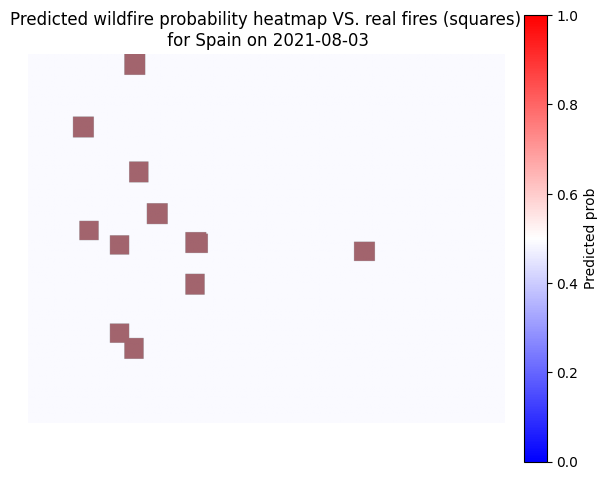

In [27]:
compare_prediction("2021-08-03")